In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import numpy as np

In [2]:
t3_folder = r"../data/t3_summary"
of_folder = r"../output/csvs/v3/vassom_total_inputs"
output_csvs = r"../output/csvs/v3"

scen_li = ['Baseline', 'Scenario_A', 'Scenario_B', 'Pristine']
rename_t3_vars = {'TOTN': 'TotN'}

# Dicts for storing results
of_dict = {}
t3_dict = {}

for scen in scen_li:
    print(scen)

    t3_fpath = os.path.join(t3_folder, f"t3_flux_to_of_{scen}.csv")
    t3_df = pd.read_csv(t3_fpath, index_col=0)

    # Drop aggregated rows
    t3_df = t3_df[~t3_df.index.isin(['Indre Oslofjord', 'Ytre Oslofjord', 'Hele Oslofjord'])]
    t3_df = t3_df.rename(rename_t3_vars, axis=1)

    of_fpath = os.path.join(of_folder, f"nog_total_of800_inputs_per_vassom_{scen}.csv")
    of_df = pd.read_csv(of_fpath, dtype={'Vassom': str}, index_col=0)

    # Remove "." from the end of the vassom numbers
    of_df.index = of_df.index.str.rstrip('.')
    of_df.index.name = "Område"

    # Drop Q
    of_df = of_df.drop('Q', axis=1)

    # Add "Hele Oslofjord"
    of_df.loc['Hele Oslofjord', :] = of_df.sum(axis=0)
    t3_df.loc['Hele Oslofjord', :] = t3_df.sum(axis=0)

    # # Drop cols from t3_df not present in of_df
    common_cols = of_df.columns.intersection(t3_df.columns)
    t3_df = t3_df[common_cols].copy()

    # Ensure both indices are strings and stripped
    t3_df.index = t3_df.index.astype(str).str.strip()
    of_df.index = of_df.index.astype(str).str.strip()

    # Add to dicts
    of_dict[scen] = of_df
    t3_dict[scen] = t3_df

    # print("Index match:", of_df.index.equals(t3_df.index))
    # print("Column match:", of_df.columns.equals(t3_df.columns))



Baseline
Scenario_A
Scenario_B
Pristine


In [3]:
of_dict['Pristine'].round(0).tail()

,TotN,DIN,SS,TOC,TDP
Område,,,,,
014,279.0,218.0,1947.0,3826.0,2.0
015,793.0,278.0,1603.0,17325.0,7.0
016,1283.0,456.0,614.0,22531.0,8.0
017,494.0,144.0,229.0,8985.0,3.0
Hele Oslofjord,10431.0,3891.0,22649.0,215511.0,92.0


# Compare inputs

In [4]:
var_li = list(t3_dict['Baseline'].columns)

res_dict = {}  # key: (scen, var)

for scen in scen_li:

    compare_dict = {}  # key: var
    for var in var_li:
        t3_s = t3_dict[scen][var].copy()
        t3_s.name = "TEOTIL3"
        of_s = of_dict[scen][var].copy()
        of_s.name = "OF800"
        df = pd.concat([t3_s, of_s], axis=1)
        compare_dict[var] = df

        # Store in master dict too
        # res_dict[(scen, var)] = df

    # Concatenate into a single df with multiindex, for writing out
    dfs_with_multiheader = []
    for var, df in compare_dict.items():
        # Add MultiIndex to columns: (var, original_col)
        df.columns = pd.MultiIndex.from_product([[var], df.columns])
        dfs_with_multiheader.append(df)

    combined_df = pd.concat(dfs_with_multiheader, axis=1)

    res_dict[scen] = combined_df

    fpath = os.path.join(output_csvs, "compare_t3_of800", f"{scen}_compare_t3_of800_by-vassom_all-vars.csv")
    combined_df.round(0).to_csv(fpath)



In [5]:
# Quick look at results
res_dict[('Baseline')].round(0)

TotN               DIN                 SS            \
                TEOTIL3    OF800  TEOTIL3    OF800   TEOTIL3     OF800   
Område                                                                   
001              1080.0   1255.0    652.0    789.0    3674.0    3447.0   
002             17089.0  14971.0  10637.0   9906.0  168175.0  170864.0   
003              1009.0   1019.0    701.0    658.0    3705.0    1991.0   
004               498.0    548.0    370.0    384.0    9942.0    5074.0   
005               343.0    334.0    242.0    221.0    1987.0     624.0   
006               600.0    489.0    422.0    308.0    2759.0    1336.0   
007                97.0    155.0     50.0     80.0    1087.0    1192.0   
008               172.0    157.0    108.0    100.0    2892.0     657.0   
009              1393.0   1969.0   1001.0   1476.0    7271.0    4822.0   
010                94.0     93.0     61.0     79.0    1173.0     367.0   
011               366.0    473.0    246.0    330.0   13426.0    8219.0   
012              5196.0   5508.0   2973.0   3763.0   26277.0   22524.0   
013               959.0    770.0    762.0    636.0   14845.0    1509.0   
014              1253.0   2164.0    940.0   1947.0   33726.0   23742.0   
015              2658.0   2240.0   1595.0   1430.0   30263.0   19548.0   
016              3596.0   3239.0   2156.0   2116.0    9185.0    7489.0   
017               548.0    639.0    241.0    248.0    1474.0    2798.0   
Hele Oslofjord  36950.0  36022.0  23155.0  24470.0  331860.0  276202.0   

                     TOC               TDP         
                 TEOTIL3     OF800 TEOTIL3  OF800  
Område                                             
001               8217.0   10719.0    10.0   27.0  
002             109182.0  111023.0   138.0  259.0  
003               4502.0    5129.0     9.0   12.0  
004               1871.0    1134.0     4.0   12.0  
005               1592.0     507.0     5.0    4.0  
006               2408.0    1257.0    13.0    7.0  
007               1586.0    1359.0     2.0    8.0  
008               1760.0    1050.0     4.0    2.0  
009               3243.0    4462.0    20.0   33.0  
010                845.0     506.0     1.0    3.0  
011               2681.0    1738.0     5.0    9.0  
012              31883.0   43652.0    43.0   43.0  
013               2895.0    2023.0     9.0    8.0  
014               5360.0    4723.0    17.0   41.0  
015              20586.0   18742.0    25.0   27.0  
016              20134.0   24621.0    29.0   27.0  
017               5582.0    9489.0     4.0    7.0  
Hele Oslofjord  224327.0  242135.0   339.0  528.0

## Whole OF inputs

In [6]:
# Make new dfs of whole oslofjord inputs, with index=scenarios, cols=vars
row_name = "Hele Oslofjord"

of_wholeof = pd.DataFrame(index=scen_li, columns=var_li, dtype=float)
t3_wholeof = pd.DataFrame(index=scen_li, columns=var_li, dtype=float)

for sc in scen_li:
    # Pick the same row from both DataFrames & add to the
    # collated df as a new row
    of_wholeof.loc[sc] = of_dict[sc].copy().loc[row_name]
    t3_wholeof.loc[sc] = t3_dict[sc].copy().loc[row_name]

# Transpose
of_wholeof = of_wholeof.transpose()
t3_wholeof = t3_wholeof.transpose()

of_wholeof['Model'] = 'OF800'
t3_wholeof['Model'] = 'Teotil3'

combined_wholeof = pd.concat([of_wholeof, t3_wholeof], axis=0)
combined_wholeof.index.name = 'Variable'

# Reorder columns so 'Model' is second
cols = ['Model'] + [c for c in combined_wholeof.columns if c not in ['Model']]
combined_wholeof = combined_wholeof[cols]

combined_wholeof = combined_wholeof.round(0).sort_index().reset_index()

fpath = os.path.join(output_csvs, "compare_t3_of800", f"t3_of800_whole-of_loads_per_scenario.csv")
combined_wholeof.to_csv(fpath)

combined_wholeof

,Variable,Model,Baseline,Scenario_A,Scenario_B,Pristine
0,DIN,OF800,24470.0,20875.0,16964.0,3891.0
1,DIN,Teotil3,23155.0,19710.0,16064.0,3557.0
2,SS,OF800,276202.0,104128.0,78165.0,22649.0
3,SS,Teotil3,331860.0,134686.0,104920.0,26318.0
4,TDP,OF800,528.0,491.0,367.0,92.0
5,TDP,Teotil3,339.0,319.0,249.0,56.0
6,TOC,OF800,242135.0,234270.0,233064.0,215511.0
7,TOC,Teotil3,224327.0,216605.0,215452.0,198162.0
8,TotN,OF800,36022.0,31506.0,26724.0,10431.0
9,TotN,Teotil3,36950.0,32507.0,27835.0,11413.0


## Percent changes from baseline

In [7]:
future_scen_li = [x for x in scen_li if x != 'Baseline']

of_pc = of_wholeof.drop('Model', axis=1).copy()

for scen in future_scen_li:
    of_pc[scen] = 100 * (1 - (of_pc[scen] / of_pc['Baseline']))

of_pc = of_pc.drop('Baseline', axis=1)

of_pc['Model'] = 'OF800'

of_pc.round(1)

,Scenario_A,Scenario_B,Pristine,Model
TotN,12.5,25.8,71.0,OF800
DIN,14.7,30.7,84.1,OF800
SS,62.3,71.7,91.8,OF800
TOC,3.2,3.7,11.0,OF800
TDP,6.9,30.4,82.6,OF800


In [8]:
future_scen_li = [x for x in scen_li if x != 'Baseline']

t3_pc = t3_wholeof.drop('Model', axis=1).copy()

for scen in future_scen_li:
    t3_pc[scen] = 100 * (1 - (t3_pc[scen] / t3_pc['Baseline']))

t3_pc = t3_pc.drop('Baseline', axis=1)

t3_pc['Model'] = 'Teotil3'

t3_pc.round(1)

,Scenario_A,Scenario_B,Pristine,Model
TotN,12.0,24.7,69.1,Teotil3
DIN,14.9,30.6,84.6,Teotil3
SS,59.4,68.4,92.1,Teotil3
TOC,3.4,4.0,11.7,Teotil3
TDP,6.0,26.5,83.6,Teotil3


In [10]:
combined_pc_wholeof = pd.concat([of_pc, t3_pc], axis=0)
combined_pc_wholeof.index.name = 'Variable'

# Reorder columns so 'Model' is second
cols = ['Model'] + [c for c in combined_pc_wholeof.columns if c not in ['Model']]
combined_pc_wholeof = combined_pc_wholeof[cols]

# Round and sort index
combined_pc_wholeof = combined_pc_wholeof.round(0).sort_index().reset_index()

# Save
fpath = os.path.join(output_csvs, "compare_t3_of800", f"t3_of800_whole-of_percent_reduction_per_scenario.csv")
combined_wholeof.to_csv(fpath)

combined_pc_wholeof

,Variable,Model,Scenario_A,Scenario_B,Pristine
0,DIN,OF800,15.0,31.0,84.0
1,DIN,Teotil3,15.0,31.0,85.0
2,SS,OF800,62.0,72.0,92.0
3,SS,Teotil3,59.0,68.0,92.0
4,TDP,OF800,7.0,30.0,83.0
5,TDP,Teotil3,6.0,26.0,84.0
6,TOC,OF800,3.0,4.0,11.0
7,TOC,Teotil3,3.0,4.0,12.0
8,TotN,OF800,13.0,26.0,71.0
9,TotN,Teotil3,12.0,25.0,69.0


## Plot

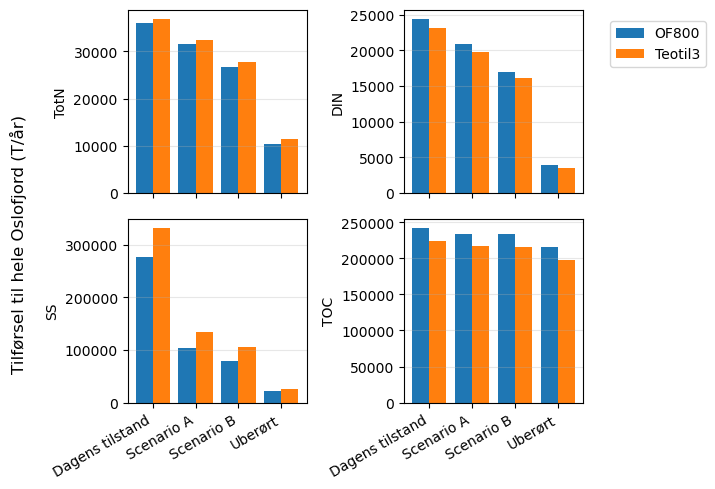

In [11]:
# Barcharts of absolute values

plot_var_li = ['TotN', 'DIN', 'SS', 'TOC']

xlabel_dict = {
    'Baseline': 'Dagens tilstand',
    'Scenario_A': 'Scenario A',
    'Scenario_B': 'Scenario B',
    'Pristine': 'Uberørt'
}

# Map scen_li to labels
mapped_labels = [xlabel_dict.get(s, s) for s in scen_li]

ncols = 2
nrows = 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2.5 * nrows), sharex=True)
axes = np.ravel(axes)

width = 0.4
x = np.arange(len(scen_li))

colors = ("#1f77b4", "#ff7f0e")

for i, var in enumerate(plot_var_li):
    ax = axes[i]
    a_vals = of_wholeof.drop('Model', axis=1).loc[var, :].astype(float).values
    b_vals = t3_wholeof.drop('Model', axis=1).loc[var, :].astype(float).values

    ax.bar(x - width/2, a_vals, width=width, color=colors[0], label="OF800")
    ax.bar(x + width/2, b_vals, width=width, color=colors[1], label="Teotil3")

    # ax.set_title(var)
    # Add title in top-left corner
    # ax.text(0.85, 0.88, f"{var}", transform=ax.transAxes, fontsize=12, va='bottom', ha='right')
    ax.set_ylabel(var)

    ax.set_xticks(x)
    ax.set_xticklabels(mapped_labels, rotation=30, ha="right")
    ax.grid(axis="y", alpha=0.3)
    # ax.legend()

    if i == 0:
        # Create a figure-level legend in the empty space (bottom right)
        fig.legend(loc='center', bbox_to_anchor=(1.1, 0.9), frameon=True)

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a single y-axis label for the entire figure
fig.supylabel('Tilførsel til hele Oslofjord (T/år)', fontsize=12)

fig.tight_layout()

fpath = r"../output/plots/v3/t3_vs_of800/scenario_summary_barplots.png"
plt.savefig(fpath)
plt.show()

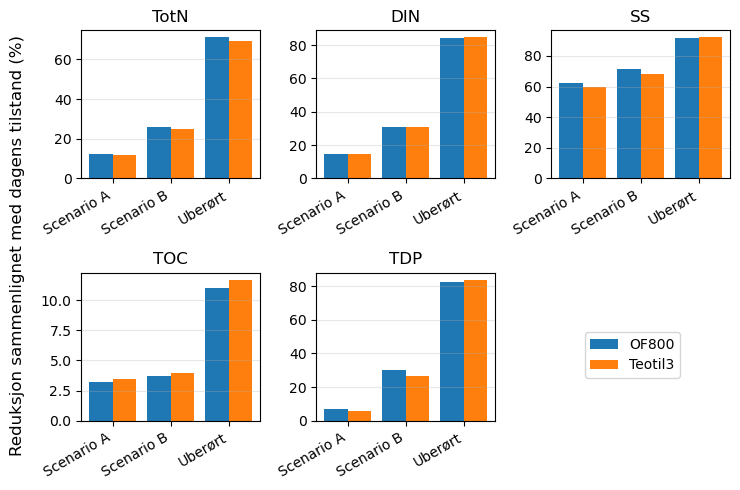

In [12]:
# Barcharts of % changes

# Map scen_li to labels
mapped_fut_labels = [xlabel_dict.get(s, s) for s in future_scen_li]

ncols = 3
nrows = math.ceil(len(var_li) / ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2.5 * ncols, 2.5 * nrows))
axes = np.ravel(axes)

width = 0.4
x = np.arange(len(future_scen_li))

colors = ("#1f77b4", "#ff7f0e")

for i, var in enumerate(var_li):
    ax = axes[i]
    a_vals = of_pc.drop('Model', axis=1).transpose()[var].astype(float).values
    b_vals = t3_pc.drop('Model', axis=1).transpose()[var].astype(float).values

    ax.bar(x - width/2, a_vals, width=width, color=colors[0], label="OF800")
    ax.bar(x + width/2, b_vals, width=width, color=colors[1], label="Teotil3")

    ax.set_title(var)
    ax.set_xticks(x)
    ax.set_xticklabels(mapped_fut_labels, rotation=30, ha="right")
    ax.grid(axis="y", alpha=0.3)

    if i == 0:
        # ax.legend()
        # Create a figure-level legend in the empty space (bottom right)
        fig.legend(loc='center', bbox_to_anchor=(0.85, 0.28), frameon=True)

# Hide unused axes if any
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Add a single y-axis label for the entire figure
fig.supylabel('Reduksjon sammenlignet med dagens tilstand (%)', fontsize=12)

fig.tight_layout()

fpath = r"../output/plots/v3/t3_vs_of800/scenario_summary_percent-change_barplots.png"
plt.savefig(fpath)
plt.show()